# MNIST 데이터 분류
* CUDA를 이용한 GPU 가속 환경이 아니면 코드를 따라하는 데 오랜 시간이 소요될 수 있습니다.
* 강의 영상의 코랩 사용법을 보고, GPU 가속 환경에서 코드를 따라해보기를 권합니다.

* 아래 코드는 텐서플로우 1이나 2 모두 동일

In [1]:
import tensorflow as tf
import keras
from keras import datasets
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Using TensorFlow backend.


* 케라스는 텐서플로우 1.15 버전을 backend로 사용

In [2]:
print('tf', tf.__version__)
print('keras', keras.__version__)

tf 1.15.0
keras 2.3.0


## 케라스 모델 만들기
케라스로 모델을 만들 때는 아래 프로세스만 생각하면 됨
1. 데이터
2. 모델 정의 (define)
3. 모델 컴파일 (compile)
4. 모델 학습 (fit)
5. 모델 평가 (evaluate)
6. 예측 (predict)

## MNIST 데이터
먼저 오늘 풀이할 데이터를 살펴보자.

In [3]:
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

데이터 모양 알아보기

In [4]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [5]:
X_test.shape, y_test.shape

((10000, 28, 28), (10000,))

데이터 범위 (최대값과 최소값) 확인

In [6]:
np.min(X_train), np.max(X_train)

(0, 255)

데이터를 0 ~ 1 범위로 rescale하기

In [7]:
# 데이터 rescale
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

* MNIST 데이터를 눈으로 확인
```python
plt.subplots(nrows, ncols)
```
* 위 함수에 도화지를 몇 분할 할 것인지 인자로 전달
* 이 예제에서는 5x5로 분할
* plt.subplots를 호출하면, 그림 요소들을 담는 fig와 분할한 도화지 요소가 담진 ax를 반환
* ax는 plt.subplots를 호출할 때 인자로 넣은 배열 그대로 그림이 그려진다고 생각하면 됨
* ax.imshow() 안에 그려줄 그림을 넣음
* ax.axis('off') 는 쓸데 없는 축이 안나타나도록 하기 위함


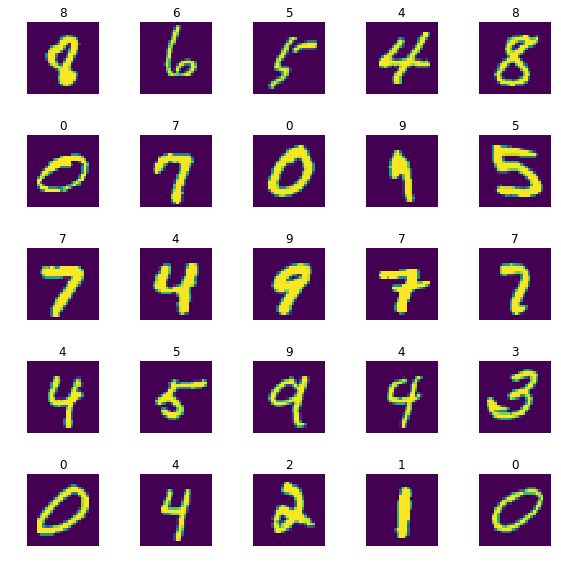

In [8]:
nrows, ncols = 5, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(8, 8))
# 분할 한 그림들이 서로 적당히 떨어지도록 함
fig.tight_layout()
for i in range(nrows):
    for j in range(ncols):
        # X_train에서 임의의 인덱스 번호를 가져와서 그림 나타냄
        idx = np.random.randint(len(X_train))
        ax[i][j].imshow(X_train[idx])
        ax[i][j].set_title(f"{y_train[idx]}")
        ax[i][j].axis('off')
plt.show()

## 다층 퍼셉트론으로 된 모델 구현하기

위에서 다룬 케라스 모델 만들기 순서에 따라 그대로 만들어보자.

1. 데이터
2. 모델 정의 (define)
3. 모델 컴파일 (compile)
4. 모델 학습 (fit)
5. 모델 평가 (evaluate)
6. 예측 (predict)

### 1. 데이터

* 데이터 하나 하나가 (총 60,000개) 정사각형 (28, 28)인 이미지이고, 그 이미지가 어떤 숫자를 나타내는지 숫자 하나로 되어 있음
* 다층 퍼셉트론은 벡터가 입력되어야 하므로 28x28 행렬을 784 길이 벡터로 펴주기
* 이 때 넘파이 ```np.reshape()```을 사용
```python
numpy.reshape(a, newshape)
```
* ```a```에 변경 전 배열, ```reshape```에 변경 후 모양

In [9]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


* 위 데이터는 (데이터 개수, 28, 28) 형태
* 이를 (데이터 개수, 784)로 변환

In [10]:
X_train = np.reshape(X_train, (len(X_train), 784))
X_test = np.reshape(X_test, ((len(X_test), 784)))

In [11]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


### 2. 모델 정의 (define)

* 모델을 정의하기 전에 먼저 무엇이 입력(input)되는지, 무엇이 출력(output)되는지 명확해야 함
  * ```X_train```, ```y_train``` 쌍을 생각해보면, 입력은 784 벡터, 출력은 10차원 원핫 인코딩
  * 원핫인코딩이란?
    * 라벨에 해당하는 벡터만 1, 나머지는 0
* 다층 퍼셉트론에 넣을 데이터는 벡터 형태로 되어있어야 함 (위에서 완료)
* 은닉층이 256개 뉴런, 128개 뉴런으로 된 다층 퍼셉트론을 쌓기
* 은닉층은 모두 ReLU 활성함수를 사용
* Sequential()을 사용하면 층층이 모델 쌓기로 구현 가능

In [12]:
from keras import models, losses, metrics, optimizers
from keras.layers import Dense, Activation

In [13]:
# 모델 생성
model = models.Sequential()

In [14]:
# 층을 하나씩 쌓는다.
# 은닉층 뉴런 256개
model.add(Dense(256))
model.add(Activation(tf.nn.relu))

# 은닉층 뉴런 128개
model.add(Dense(128))
model.add(Activation(tf.nn.relu))

# 출력 뉴런 10개
model.add(Dense(10))
model.add(Activation(tf.nn.softmax))

### 3. 모델 컴파일 (compile)
* 모델에서 어떤 손실함수를 쓸지 정함
  * 여기서는 sparse categorical cross entropy 사용
      * 실제 데이터는 0 ~ 9 숫자가 담김
      * 모델은 10차원 벡터로 된 원핫 인코딩
      * 이 두 가지로부터 정확도를 측정하는 방법임
* 모델 업데이트를 어떤 방법을 써서 할지 정함
  * Adam 최적화기 사용
* 모델 학습하는 동안 사용할 모델 평가 방법 정함
  * 정확도 사용

In [15]:
model.compile(
    loss=losses.SparseCategoricalCrossentropy(), 
    optimizer=optimizers.Adam(learning_rate=1e-4), 
    metrics=['acc']
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### 4. 모델 학습 (fit)
* 싸이킷런과 유사하게 fit을 사용
* fit에 필수적으로 사용하는 인자는
```python
model.fit(x, y, batch_size, epochs, verbose, validation_split
```
* ```x```: 입력 데이터
* ```y```: 출력 데이터
* ```epochs```: 업데이트 할 횟수
* ```verbose```: 학습하는 정보를 얼마나 출력할지. 0이면 아무것도 출력 안함. 1이면 가장 자세한 정보 출력. 2면 간단 출력
* ```validation_split```: 학습 데이터에서 몇 퍼센트를 모델 중간 평가에 쓸지

In [16]:
history = model.fit(
    x=X_train, y=y_train, 
    batch_size=256,
    epochs=50,
    verbose=1, 
    validation_split=.25
)


Train on 45000 samples, validate on 15000 samples
Epoch 1/50
45000/45000 [==============================] - 1s 28us/step - loss: 1.2236 - acc: 0.6990 - val_loss: 0.5090 - val_acc: 0.8809
Epoch 2/50
45000/45000 [==============================] - 1s 20us/step - loss: 0.4083 - acc: 0.8957 - val_loss: 0.3218 - val_acc: 0.9139
Epoch 3/50
45000/45000 [==============================] - 1s 20us/step - loss: 0.2998 - acc: 0.9177 - val_loss: 0.2689 - val_acc: 0.9263
Epoch 4/50
45000/45000 [==============================] - 1s 21us/step - loss: 0.2541 - acc: 0.9290 - val_loss: 0.2372 - val_acc: 0.9343
Epoch 5/50
45000/45000 [==============================] - 1s 21us/step - loss: 0.2237 - acc: 0.9379 - val_loss: 0.2149 - val_acc: 0.9401
Epoch 6/50
45000/45000 [==============================] - 1s 20us/step - loss: 0.2018 - acc: 0.9438 - val_loss: 0.2009 - val_acc: 0.9448
Epoch 7/50
45000/45000 [==============================] - 1s 21us/step - loss: 0.1839 - acc: 0.9484 - val_loss: 0.1884 - val_ac

### 5. 모델 평가 (evaluate)

* 모델 fit은 history 오브젝트를 반환 함
* history오브젝트의 history는 학습하는 동안 모델의 정확도, loss를 기록함

In [17]:
history.history

{'val_loss': [0.5090467067400615,
  0.3218139631271362,
  0.26893271829287213,
  0.2371834886153539,
  0.21489435845216115,
  0.20085834805965425,
  0.1883547921260198,
  0.17673780795733135,
  0.16820485229492188,
  0.1599969088713328,
  0.15357512345314026,
  0.14983714029788972,
  0.143794749434789,
  0.13954194595813751,
  0.13423360214233399,
  0.1315743680159251,
  0.12720586822032928,
  0.1267248301188151,
  0.12271418336232504,
  0.12005586944421133,
  0.11985769008000692,
  0.11530935803254445,
  0.11494003718694051,
  0.11357387518088023,
  0.11098072344462077,
  0.10966562353769937,
  0.10872282294432323,
  0.10724954523245493,
  0.10507869540850322,
  0.10359988673528035,
  0.10331810717582703,
  0.1014848730802536,
  0.10137175575892131,
  0.1007508397658666,
  0.10073897330760956,
  0.10090080411434174,
  0.09847974080244701,
  0.10025885885556539,
  0.09883470865090688,
  0.0999327718337377,
  0.096816233197848,
  0.09750526447296143,
  0.09718622163931528,
  0.095824275

그림으로 정확도, loss를 그려보기

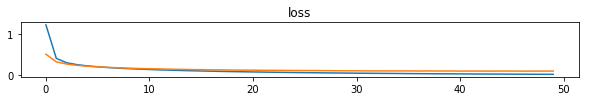

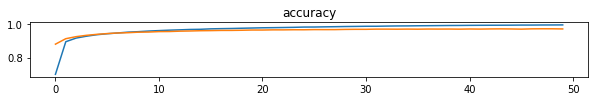

In [18]:
plt.figure(figsize=(10, 1))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('loss')
plt.show()

plt.figure(figsize=(10, 1))
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.title('accuracy')
plt.show()

### 6. 예측 (predict)

* 케라스 모델 예측도 역시 사이킷런과 유사하게 predict사용
```python
model.predict(x, batch_size, verbose)
```
* ```x```: 예측에 쓸 데이터
* (예측 데이터 개수) x (출력층 뉴런 수) 로 된 예측 데이터 반환

In [19]:
y_pred = model.predict(x=X_test)
y_pred.shape

(10000, 10)

In [20]:
y_test.shape, y_pred.shape

((10000,), (10000, 10))

* 예측 정확도 확인

In [21]:
assert y_test.shape[0] == y_pred.shape[0]

acc = 0

for i in range(y_test.shape[0]):
    if y_test[i] == np.argmax(y_pred[i]):
        acc += 1

print(acc * 100 / y_test.shape[0], '%')

97.63 %
